## House Prices: Advanced Regression Techniques

W207 Final Project
<br>
Teddy Fong, Ross MacLean, Alex West

The dataset selected for this project was obtained from Kaggle's current list of open competitions (https://www.kaggle.com/c/house-prices-advanced-regression-techniques). This competition uses the Ames Housing Dataset compiled by Dean De Cock.

Ask a home buyer to describe their dream house, and they probably won't begin with the height of the basement ceiling or the proximity to an east-west railroad. But this playground competition's dataset proves that much more influences price negotiations than the number of bedrooms or a white-picket fence.  With 79 explanatory variables describing (almost) every aspect of residential homes in Ames, Iowa, this competition challenges you to predict the final price of each home.  The following workbook documents our team's process in full - from exploratory data analysis, to preprocessing, model selection and evaluation.

In [69]:
# General libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
%matplotlib inline

# Preprocessing and stats libraries
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from scipy import stats

# SK-learn libraries for regression
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import VotingRegressor

# SK-learn libraries for evaluation
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import mean_squared_error
from sklearn.metrics import confusion_matrix
from sklearn import metrics

In [70]:
import warnings
warnings.filterwarnings('ignore')

## Exploratory Data Analysis

In [71]:
# Read in the housing train data
train = pd.read_csv('../Data/train.csv', index_col=0)
train.reset_index(drop=True, inplace=True)

# Read in the test data
test = pd.read_csv('../Data/test.csv', index_col=0)

# Shapes of datasets
print('Train data:', np.array(train).shape)
print('Test data:', np.array(test).shape)

Train data: (1460, 80)
Test data: (1459, 79)


### Missing Values

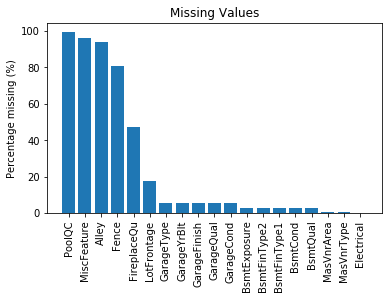

In [72]:
def plot_missing(train=train):
    '''Plot all features with missing values. Accepts
    dataframe as input. Displays bar graph showing
    percentage of missing values by feature.
    '''
    # Calculate missing value counts
    missing = train.isnull().sum()
    missing = pd.DataFrame(missing[missing > 0])

    # Rename and sort counts
    missing.columns = ['count']
    missing.sort_values(by='count', ascending = False, inplace = True)

    # Percentage missing
    missing['percent_missing'] = missing['count'] / len(train.index) * 100

    # Plot missing counts
    fig, ax = plt.subplots(figsize = (6,3.5))
    plt.bar(missing.index, missing['percent_missing'])
    plt.title('Missing Values')
    plt.ylabel('Percentage missing (%)')

    # Rotate x labels
    for tick in ax.get_xticklabels():
        tick.set_rotation(90)
        
plot_missing()

In [73]:
def return_variable_types(data=train):
    '''Divide dataset columns into qualitative and quantitative array.
    Accepts training data as an input.  Returns a list containing
    list elements of qualitative and quantitative feature names.
    '''
    # Group variables by type
    qualitative = [var for var in data.columns if np.dtype(data[var]) == 'object'].copy()
    quantitative = [var for var in data.columns if np.dtype(data[var]) != 'object'].copy()
    
    return qualitative, quantitative

In [74]:
def replace_missing(data=train):
    '''Replace missing values for qualitative and quantitative
    variables accordingly. Accepts dataframe as an input. 
    Outputs a new dataset with missing values replaced.
    '''

    # Group variables by type
    qualitative, quantitative = return_variable_types(data=data)

    # Identify missing values
    missing = data.columns[data.isnull().any()]

    # Replace with appropriate value according to type
    for col in missing:
        if col in qualitative:
            data[col] = data[col].fillna('None')
        elif col in quantitative:
            data[col] = data[col].fillna(0)      
    return data

### Correlations

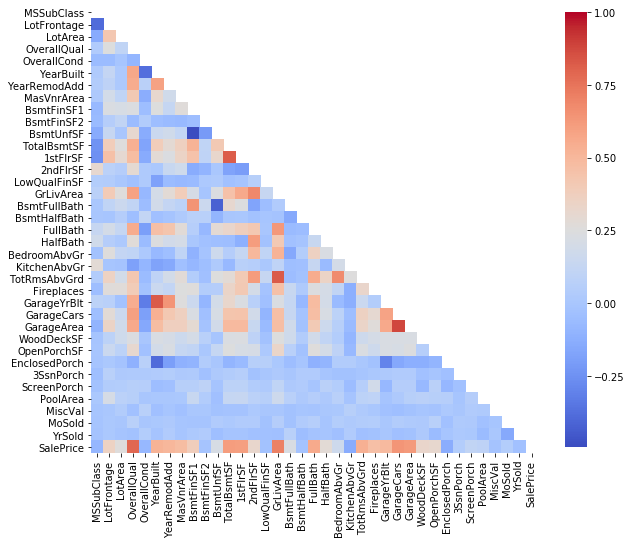

In [75]:
def correlation_matrix(train=train):
    '''Plot correlation matrix for dataset. Accepts
    dataframe as input. Displays upper triangular
    heat map of correlations.
    '''  
    # Create correlation matrix
    corr = train.corr()

    # Define figure size
    plt.rcParams['figure.figsize'] = (10, 10)

    # Mask upper triangle
    mask = np.zeros_like(corr)
    mask[np.triu_indices_from(mask)] = True

    # Plot heapmat
    sns.heatmap(corr, mask=mask, square=True, cmap='coolwarm', cbar_kws={"shrink": 0.8})
    
correlation_matrix()   

The correlation plot shows there are a number of variables that are highly correlated, e.g. Overall Quality and Sale Price.  The extent to which the different variables are correlated will need to be taken into consideration when selecting the appropriate regression model.  For instance, we'll want to avoid a high degree of multicollinearity in order to minimize the bias with our model.

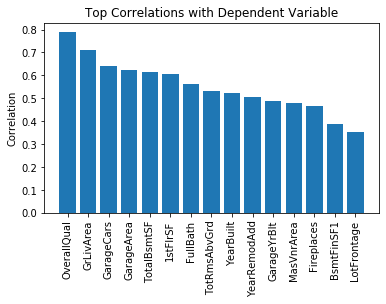

In [76]:
def plot_top_correlations(train=train, n=15):
    '''Plot the top n features that are positively correlated
    with sales price.  Accepts inputs of dataframe and integer
    of top n features to display.  Outputs bar graph of top n
    features by correlation strength.
    '''
    # SalePrice correlations
    corr = train.corr()
    saleprice_corr = pd.DataFrame(corr.loc[['SalePrice'], :].unstack())

    # Reformat df and sort
    saleprice_corr.rename(columns= {0: 'SalePrice'}, inplace = True)
    saleprice_corr.reset_index(level=1, drop=True, inplace=True)
    saleprice_corr.sort_values(by='SalePrice', ascending = False, inplace = True)

    # Top 15 variables most strongly correlated with SalePrice
    saleprice_top_15 = saleprice_corr.iloc[1:n+1, :]
    
    # Plot top correlations
    fig, ax = plt.subplots(figsize = (6,3.5))
    plt.bar(saleprice_top_15.index, saleprice_top_15['SalePrice'])
    plt.title('Top Correlations with Dependent Variable')
    plt.ylabel('Correlation')

    # Rotate x labels
    for tick in ax.get_xticklabels():
        tick.set_rotation(90)

plot_top_correlations()

The 15 variables displayed above are those most strongly correlated with SalePrice, our dependent variable.  It's worth noting that some of thse variables are highly correlated with one another (e.g. GarageCars/GarageArea, GrLivArea/TotRmsAbvGrd) and so such pairings should be avoided when specifying the linear regression model so as not to confound results.

### Pairplots

A series of pair plots are presented for a subset of quantitative features in the training dataset. Regression models operate on the assumption that the independent variables are normally distribution, and it can be seen that the distributions of the key features outlined below meet this requirement. An additional observation is that all of the features presented below are positively correlated with the dependent variable, sales price.  This makes sense considering that they measure the overall quality or some aspect of the property's size.  Interestingly, homes built more recently tend to sell for more and new homes continue to be built at a faster rate than before, indicating continued population growth in Ames.

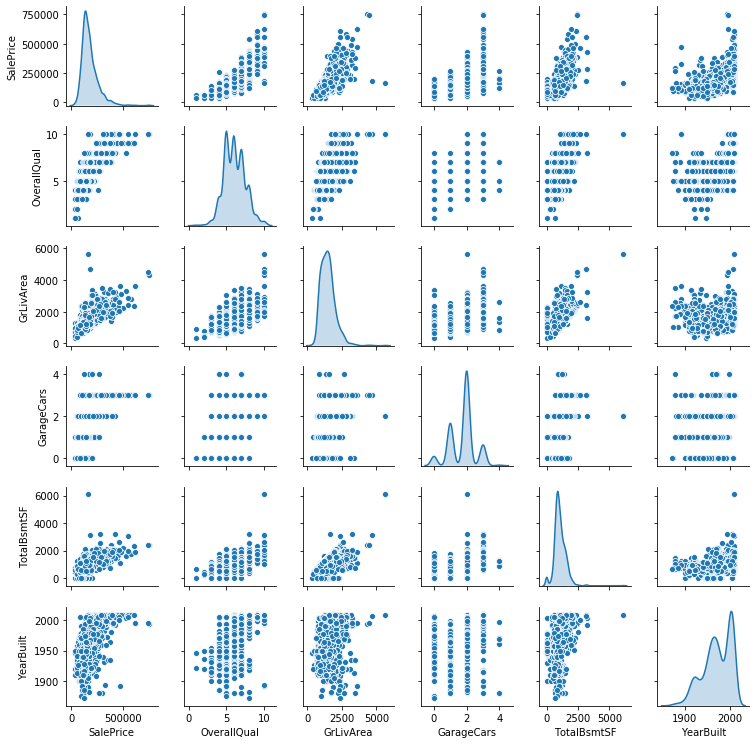

In [77]:
def pairplots(train=train):
    '''Plot the distributions of all quantitative variables
    contained in the raw training data.
    '''
    # Replace missing for train
    train_data = replace_missing(train)
    
    # Generate plot for key features
    cols = ['SalePrice', 'OverallQual', 'GrLivArea', 'GarageCars', 'TotalBsmtSF', 'YearBuilt']
    sns.pairplot(train_data[cols], diag_kind='kde', size = 1.75)
    plt.show()

pairplots()

### The Dependent Variable - Sale Price

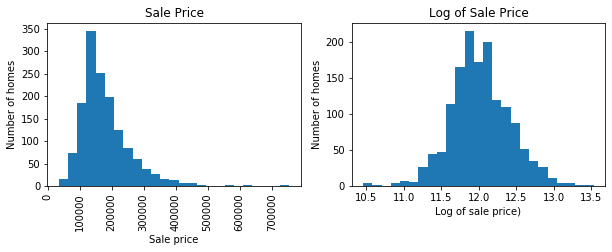

In [78]:
def plot_sale_price(train=train):
    '''Plots the distribution of sales prices (dependent variable).
    Accepts dataframe as input.  Displays distribution of sales
    prices (untransformed) and transformed logarithmically.
    '''
    # Define figure
    fig, axes = plt.subplots(1,2, figsize = (10,3))

    # Histogram of sale price
    axes[0].hist(train.SalePrice, bins=25)
    axes[0].set_title('Sale Price')
    axes[0].set_xlabel('Sale price')
    axes[0].set_ylabel('Number of homes')

    # Rotate x labels
    for tick in axes[0].get_xticklabels():
        tick.set_rotation(90)

    # Histogram of log(sale price) 
    axes[1].hist(np.log(train.SalePrice), bins=25)
    axes[1].set_title('Log of Sale Price')
    axes[1].set_xlabel('Log of sale price)')
    axes[1].set_ylabel('Number of homes')

plot_sale_price()

In [79]:
print('Descriptive stats for sale price:')
pd.DataFrame(round(train.SalePrice.describe(),2))

Descriptive stats for sale price:


,SalePrice
count,1460.0
mean,180921.2
std,79442.5
min,34900.0
25%,129975.0
50%,163000.0
75%,214000.0
max,755000.0


### Combine Datasets

In [80]:
def create_full_dataset(train=train, test=test):
    '''Combine train and test data into a full dataset to enable
    transformations to be applied more easily. Accepts inputs
    of train data and test data.  Outputs a full dataset with
    all features, minus the dependent variable (sales price).
    '''
    # Create full data without SalePrice
    full_data = pd.concat((train.loc[:, train.columns != 'SalePrice'], test)).reset_index(drop=True)

    # Replace with appropriate value according to type
    full_data = replace_missing(data=full_data)  
    return full_data.copy()

### Encoding the Data

In this project, regressors are being used to predict the output variable, sale price.  It is therefore necessary to transform all qualitative feature values to suitable numerical values before passing the dataset to the regression model.  This transformation can be performed using either label encoding or one hot encoding.  Unfortunately, it seems it is not possible to incorporate label or one hot encoding as a preprocessing step using Pipeline, and as such, it is necessary to apply any encoding manually to full dataset before training any regression models.

### Label Encoding

Label encoding transforms all strings values to an integer, e.g. Neighborhood's of NorthAmes, OldTown and Sawyer are transformed to 1, 2 and 3 respectively.  The issue here is that their numerical representations may be interpreted as ordinal when in fact there's no ordinal relationship is present.  For instance, our model may incorrectly interpret that as neighborhood number increases, so too does sale price.

In [81]:
def label_encoder(full_data, columns):
    '''Label encode specified dataframe columns. Accepts
    inputs of pandas dataframe and columns to be encoded.
    Outputs a label encoded data frame.
    '''
    # Label encode all qualitative variables
    for col in columns:
        label_encoder = LabelEncoder()
        label_encoder.fit(list(full_data[col].values)) 
        full_data[col] = label_encoder.transform(list(full_data[col].values))
    return full_data

### One Hot Encoding

One hot encoding creates a series of binary flags representing the presence of a given qualitative feature value.  Reusing using the previous example, three new variables would be created to represent the 3 neighborhoods.  While this approach mitigates against the issue of creating fictitious ordinal relationships, it greatly increases our feature space which may be problematic in some scenarios.

In [82]:
def one_hot_encoder(full_data, qualitative, quantitative):
    '''One hot encodes specified dataframe columns. Accepts
    inputs of pandas dataframe and columns to be encoded.
    Outputs a one hot encoded data frame.
    '''
    encoded = full_data[quantitative]
        
    # One hot encode all qualitative variables
    for col in qualitative:
        dummies = pd.get_dummies(full_data[col], prefix=col, sparse=False, drop_first=False)
        encoded = pd.concat([encoded, dummies], axis=1)
    return encoded

In [83]:
def encode_data(train=train, test=test, encoder='none'):
    
    # Combined train and test
    full_transformed = create_full_dataset(train=train, test=test)
    
    # Variable types
    qualitative = [var for var in full_transformed.columns if np.dtype(full_transformed[var]) == 'object']
    quantitative = [var for var in full_transformed.columns if np.dtype(full_transformed[var]) != 'object']
    
    # Type of encoding
    if encoder == 'label_encoder':
        full_transformed = label_encoder(full_transformed, qualitative)
    elif encoder == 'onehot_encoder':
        full_transformed = one_hot_encoder(full_transformed, qualitative, quantitative)
    else:
        full_transformed
        
    return full_transformed

### Split the Data

Prior to running any models, it is necessary to develop consistent process when applying transformations features whether imputing values, performing feature engineering or encoding variables.  Any transformation applied to the training data must also be applied to the test set, otherwise the predictive power of the regressor will be negatively impacted.  Following any such transformations, it is then necessary to randomly split the training data (80/20) into a new train and dev set.  This will make it posible to assess how effectively each regression model predict house sales price.  

In [84]:
def split_full_dataset(full_data, train=train):
    '''Splits the full dataset into required component parts
    for model training/testing.  Accepts inputs of full_data
    and train data. Outputs dataframes of train_data,
    train_labels, dev_data dev_labels, test_data.
    '''
    # Cut point for train/test post feature engineering
    cut = train.shape[0]
    
    # Recreate train and test sets
    train_data = full_data[:cut]
    y_label = list(train.loc[:, 'SalePrice'])
    train_data.loc[:, 'SalePrice'] = y_label
    test_data = full_data[cut:]

    # Random splits for train and dev sets
    train_set = train_data.sample(frac=0.8, random_state=0)
    dev_set = train_data.drop(train_set.index)

    # Select specified features for each dataset
    train_data, train_labels = train_set.loc[:, train_set.columns != 'SalePrice'], train_set.loc[:, 'SalePrice']
    dev_data, dev_labels = dev_set.loc[:, dev_set.columns != 'SalePrice'], dev_set.loc[:, 'SalePrice']
    
    return train_data, train_labels, dev_data, dev_labels, test_data

The method of evaluation for this Kaggle competition is the Root Mean Squared Error (RMSE) between the logarithm of predicted sale price and true sale price, ensuring prediction error for both cheap and expensive houses will affect results equally.

In [85]:
def root_mean_squared_error(y_value, y_predict):
    '''Calculate the root mean square error (RMSE). Accepts
    inputs of actual y value and predicted y value. Returns
    the RMSE as a float.
    '''
    return np.sqrt(mean_squared_error(y_value, y_predict))

## Model Building

### Basic Linear Model

In [56]:
def linear_regression(encoder='none', plots=True, train=train, test=test):
    '''Fit linear regression model, predict dependent variable and
    display scatter plot with regression line and residual plot.
    Accepts inputs of full_data and encoding type (none, label or
    one hot). Returns model accuracy, RMSE and plots.
    '''
    full_data = encode_data(train=train, test=test, encoder=encoder)

    # Encode and split dataset 
    train_data, train_labels, dev_data, dev_labels, test_data = split_full_dataset(full_data, train=train)
    
    # Log of sales price
    train_labels_log = np.log(train_labels)
    dev_labels_log = np.log(dev_labels)

    # Fit the linear regression model
    lr = LinearRegression()
    lr.fit(train_data, train_labels_log)
    predict_dev_log = lr.predict(dev_data)
    predict_dev_value = np.exp(predict_dev_log)
    
    if plots == True:

        # Plot predicted vs. actual values
        fig, axes = plt.subplots(1,2,figsize = (11.5,4))

        # Calculate regression line
        slope, intercept, r_value, p_value, std_err = stats.linregress(dev_labels, predict_dev_value)
        line_x = np.arange(dev_labels.min(), dev_labels.max())
        line_y = slope*line_x + intercept

        # Plot data and regression line
        axes[0].scatter(predict_dev_value, dev_labels)
        axes[0].plot(line_x, line_y, color='red', linestyle = '--')

        axes[0].set_title('Linear Regression: Actual vs. Predicted')
        axes[0].set_xlabel('Predicted price')
        axes[0].set_ylabel('Actual price')

        # Plot residuals
        axes[1].scatter(predict_dev_value, predict_dev_value - dev_labels, color='black', s=20)
        axes[1].hlines(y=0, xmin= 0, xmax=500000, colors='red')

        axes[1].set_title('Residuals: Variance of Fitted Values')
        axes[1].set_xlabel('Predicted price')
        axes[1].set_ylabel('Variance from actual')
        axes[1].set_ylim(-160000,150000)

        fig.tight_layout()
    
    # R^2 and root mean squared error
    print('Linear Regression with', encoder)
    print('Features: {}'.format(full_data.shape[1]))
    print('R^2: {:.4f}'.format(lr.score(dev_data, dev_labels_log)))
    print('RMSE: {:.4}'.format(root_mean_squared_error(dev_labels_log, predict_dev_log)))

Linear Regression with label_encoder
Features: 79
R^2: 0.8761
RMSE: 0.1317


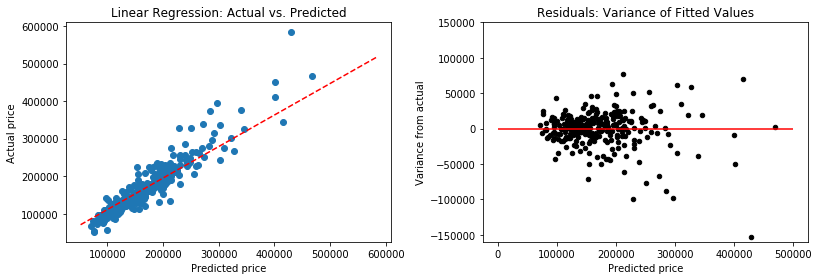

In [57]:
linear_regression(encoder='label_encoder')

The basic linear regression model with label encoding acheived an R^2 of 0.8761 when predicting on the dev data.  It should be noted however that as house price increases, there's a tendancy for the predicted value to exhibit greater variance from the true sale price.  This is confirmed by the above residual plot, revealing the presence of non-constant variance (heteroskedasticity), indicating that our modeling process may benefit from further preprocessing (e.g. transforming features, removing outliers) and regularization.

As we add more features to our model, it's complexity increases which in turn increases variance and reduces bias.  This makes the model more prone to overfitting.  The goal is to find the optimal point where the decrease in bias is equal to the increase in variance.  To achieve this it is necessary to either reduce model complexity or introduce regularization.  The next section will look at the modeling effects of Lasso Regression, which uses L1 regularization to select features with the greatest coefficients.

### Lasso Regression

Lasso Regression performs L1 regularization to minimize the Residual Sum of Squares (RSS) plus the sum of absolute value of the magnitude of the coefficient weights.  The effect is that the magnitude of the coefficients shrinks as alpha is increased, thereby reducing the featurs space.  It is an effective ways to select those features that best describe the variance of the dependent variable, in this case Sale Price.  Our data also contains a number of highly correlated variables, and lasso regression accounts for this by arbitrarily select one of the features and setting the coefficient size to zero for all others.

Lasso Regression with label_encoder
Best alpha: 0.0001
Features: 56
R^2: 0.8795
RMSE: 0.1299


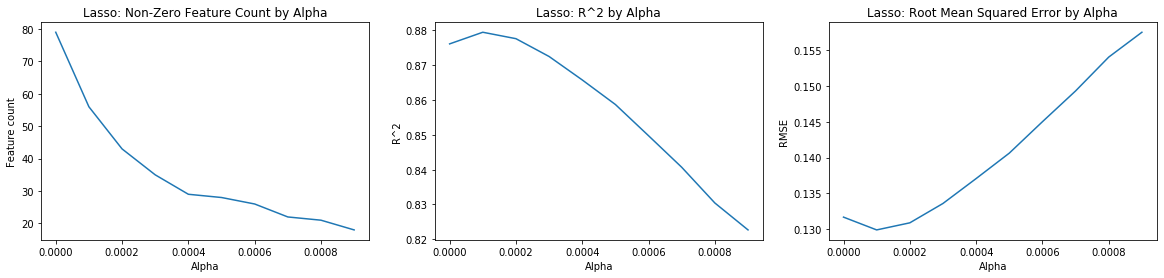

In [58]:
def lasso_regression(alphas, encoder='none', transform=False, plots=False, train=train, test=test):
    '''Fit lasso regression model, make predictions and
    display results. Accepts input of full_data and
    returns (prints) model accuracy and RMSE.
    '''
    # Lasso with alpha=0 is the same as OLS.
    # Accuracy should match basic linear regression (it does).
    
    # Encode or transform
    if transform == True:
        full_data = transform_categorical(encoder=encoder)
    else:
        full_data = encode_data(encoder=encoder)
    
    # Encode and split dataset 
    train_data, train_labels, dev_data, dev_labels, test_data = split_full_dataset(full_data, train=train)
    train_labels_log, dev_labels_log = np.log(train_labels), np.log(dev_labels)

    # Parameters
    alphas = alphas
    feature_count = []
    r2 = []
    rmse = []

    for alpha in alphas:

        # Lasso - fit the model and predict
        lasso = Lasso(alpha=alpha, normalize=True)
        lasso.fit(train_data, train_labels_log)
        predict_dev_log = lasso.predict(dev_data)

        # Append accuracy/results
        r2.append(lasso.score(dev_data, dev_labels_log))
        rmse.append(root_mean_squared_error(dev_labels_log, predict_dev_log))

        # Feature coefficients
        features = train_data.columns
        df = pd.DataFrame({'feature': features, 'coef': lasso.coef_})
        df.sort_values(by='coef', inplace=True)
        trimmed_features = df.loc[df['coef'] != 0]
        
        # Number of non-zero features
        feature_count.append(len(list(trimmed_features['feature'])))
    
    # Zip scores
    outputs = tuple(zip(rmse, r2, feature_count))

    # Dictionary of results
    results = dict(zip(alphas, outputs))
    best = min(results, key=results.get)
    print('Lasso Regression with', encoder)
    print('Best alpha:', best)
    print('Features: {}'.format(results[best][2]))
    print('R^2: {:.4f}'.format(results[best][1]))
    print('RMSE: {:.4f}'.format(results[best][0]))
    
    if plots == True:

        # Plot coefficients
        fig, axes = plt.subplots(1,3,figsize = (20,4))

        # Feature count
        axes[0].plot(alphas, feature_count)
        axes[0].set_title('Lasso: Non-Zero Feature Count by Alpha')
        axes[0].set_xlabel('Alpha')
        axes[0].set_ylabel('Feature count')

        # R^2
        axes[1].plot(alphas, r2)
        axes[1].set_title('Lasso: R^2 by Alpha')
        axes[1].set_xlabel('Alpha')
        axes[1].set_ylabel('R^2')

        # RMSE
        axes[2].plot(alphas, rmse)
        axes[2].set_title('Lasso: Root Mean Squared Error by Alpha')
        axes[2].set_xlabel('Alpha')
        axes[2].set_ylabel('RMSE')

lasso_regression(alphas=np.arange(0,0.001,0.0001), encoder='label_encoder', plots=True)

The best alpha (n=0.0001) resulted in an R^2 of 0.8795, meaning the 56 features (independent variables) selected explain close to 88% of the variance observed in the dependent variable sales price.  This represents a minor increase in predictive power compared to the unregularized lasso model (R^2 +0.0026) while noteably reducing the feature space from 79 to 56 features.

Lasso Regression with label_encoder
Alpha: 0.0007
R^2: 0.8407
RMSE: 0.1493


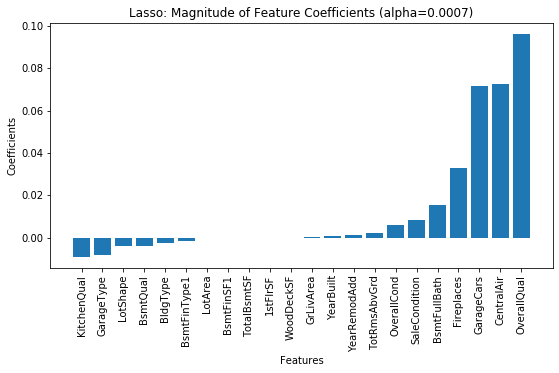

In [59]:
def lasso_coefficients(alpha, encoder='none', transform=False, color='C0', train=train, test=test):
    '''Fit lasso regression model, make predictions and
    display results. Accepts input of full_data and
    returns (prints) model accuracy and RMSE.
    '''
    # Lasso with alpha=0 is the same as OLS.
    # Accuracy should match basic linear regression (it does).

    # Encode or transform
    if transform == True:
        full_data = transform_categorical(encoder=encoder)
    else:
        full_data = encode_data(encoder=encoder)
    
    # Encode and split dataset 
    train_data, train_labels, dev_data, dev_labels, test_data = split_full_dataset(full_data, train=train)
    train_labels_log, dev_labels_log = np.log(train_labels), np.log(dev_labels)

    # Lasso - fit the model and predict
    lasso = Lasso(alpha=alpha, normalize=True)
    lasso.fit(train_data, train_labels_log)
    predict_dev_log = lasso.predict(dev_data)
    
    # Parameters and results
    print('Lasso Regression with', encoder)
    print('Alpha:', alpha)
    print('R^2: {:.4f}'.format(lasso.score(dev_data, dev_labels_log)))
    print('RMSE: {:.4}'.format(root_mean_squared_error(dev_labels_log, predict_dev_log)))
    
    # Feature coefficients
    features = train_data.columns
    df = pd.DataFrame({'feature': features, 'coef': lasso.coef_})
    df.sort_values(by='coef', inplace=True)
    trimmed_features = df.loc[df['coef'] != 0]

    # Plot coefficients
    fig, ax = plt.subplots(figsize = (9,4.5))
    plt.bar(trimmed_features['feature'], trimmed_features['coef'], color=color)

    plt.title('Lasso: Magnitude of Feature Coefficients (alpha={})'.format(alpha))
    plt.ylabel('Coefficients')
    plt.xlabel('Features')

    # Rotate x labels
    for tick in ax.get_xticklabels():
        tick.set_rotation(90)
        
lasso_coefficients(alpha=0.0007, encoder='label_encoder')

Performing L1 regularization with an alpha of 0.0007, the feature space has now reduced to 22 features - the subset of features that are the best indicators of sales price for that alpha.  The above coefficient plot shows the effect of a one unit increase in each feature on the percentage change of house sale price.  Features associated with the largest percentage increase on sales price are:

1. Overall Quality
2. Central Air
3. Garage Cars
4. Fireplaces
5. Basement Full Bath
6. Sale Condition
7. Overall Condition

Intuitively, each of these features would be expected to have a positive effect of Sale Price.  Overall Quality (scored 1-10) of the home is understandably a strong predictor of sales price which is why a unit increase in the Overall Quality is associated with the largest increase in sales price.  It is worth noting features CentralAir, GarageCars and Fireplaces have larger coefficients stemming from their units of measurement.  For instance, a unit increase in the number of garage cars has a larger impact on sales price than a unit increase in the squared-footage of the garage area. 

It can also be seen that Kitchen Quality appears to have a negative effect on Sale Price which seems counter-intuitive.  Closer inspection revealed that this nuance stems from label encoding, as a lower value in fact represents improved quality.  Nonetheless, Lasso Regression with L1 regulatization and label encoding results in a model less prone to overfitting, with improved interpretability, while suffering only a modest reduction in predictive power when compared to the baseline Linear Regression model (R^2 of 0.8407 vs. 0.8763).  

In [60]:
def multicollinearity(n=5, train=train):
    '''Identify features that are highly correlated
    Accepts inputs of top n features to display and
    return a data frame of highly correlated pairs.
    '''
    # Unstack correlation matrix
    corr = pd.DataFrame(train.corr().unstack().sort_values().drop_duplicates())

    # Rename columns
    corr.reset_index(inplace=True)
    corr.columns = ['feature1', 'feature2','correlation']
    corr.sort_values(by='correlation', ascending=False, inplace=True)

    # Remove correlations with sale price
    corr = corr[corr['feature1'] != 'SalePrice']
    corr = corr[corr['feature2'] != 'SalePrice']

    # Show top n
    return corr.iloc[1:n+1]

multicollinearity()

,feature1,feature2,correlation
665,GarageCars,GarageArea,0.882475
664,TotRmsAbvGrd,GrLivArea,0.825489
663,1stFlrSF,TotalBsmtSF,0.819530
660,2ndFlrSF,GrLivArea,0.687501
659,TotRmsAbvGrd,BedroomAbvGr,0.676620


As mentioned, lasso regression accounts for highly correlated variables by setting the magitude of one of such features to zero and omitting from the model.  To confirm this, the table above contains pairs of features with high degrees of multicollinearity, all of which are strong predictors of Sale Price. Following L1 regularization, it can be observed that only one feature within each highly correlated pair has been retained in the previous feature plot.  An additional observation is that when highly correlated features differ primarily due to units of measurement, the feature with the smallest unit of measurement is dropped from the model due to having a smaller coefficient, e.g. GarageCars is retained over GarageArea.

### Lasso with One Hot Encoding

To mitigate against the detrimental effects of label encoding qualitative features, one hot encoding can be applied instead. This approach ensures that the regression model will not interpret any false ordinal relationships in the data, as is the case with label encoding.  The following section will briefly compare and contrast the effects of one hot encoding compared to that of label encoding. Additional transformations will also be applied to the data with certain categorical features being transformed as such, e.g.  Kitchen Quality where a zero value in fact represents "Excellent" quality.

In [61]:
def transform_categorical(train=train, test=test, encoder='none'):
    
    full_transformed = create_full_dataset(train=train, test=test)
    
    # Transform to qualitative
    full_transformed['KitchenQual'] = full_transformed['KitchenQual'].astype(str)
    full_transformed['OverallQual'] = full_transformed['OverallQual'].astype(str)
    full_transformed['OverallCond'] = full_transformed['OverallCond'].astype(str)
    full_transformed['MSSubClass'] = full_transformed['MSSubClass'].astype(str)

    # Variable types
    qualitative = [var for var in full_transformed.columns if np.dtype(full_transformed[var]) == 'object']
    quantitative = [var for var in full_transformed.columns if np.dtype(full_transformed[var]) != 'object']

    # Type of encoding
    if encoder == 'label_encoder':
        full_transformed = label_encoder(full_transformed, qualitative)
    elif encoder == 'onehot_encoder':
        full_transformed = one_hot_encoder(full_transformed, qualitative, quantitative)
    else:
        full_transformed
        
    return full_transformed

In [62]:
lasso_regression(alphas=np.arange(0,0.001,0.0001), encoder='onehot_encoder', transform=True, plots=False)

Lasso Regression with onehot_encoder
Best alpha: 0.0001
Features: 137
R^2: 0.9223
RMSE: 0.1043


Performing Lasso Regression, optimized for an alpha of 0.0001, one hot encoding results in an improved R^2 of 0.9223.  This represents an increase of 0.0434 compared to label encoding.  This improvement in predictive power however it comes at a price, as the feature space has now increased in dimensionality to 137 features, more than double that of the label encoded model (n=56).

Lasso Regression with onehot_encoder
Alpha: 0.0007
R^2: 0.8622
RMSE: 0.1389


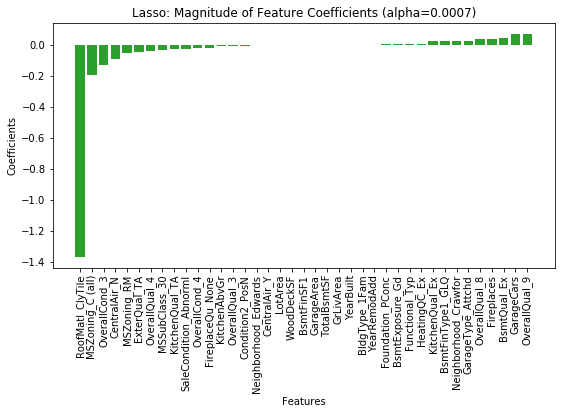

In [63]:
lasso_coefficients(alpha=0.0007, encoder='onehot_encoder', transform=True, color='C2')

The feature coefficients for a Lasso model, one hot encoded and regularized for an alpha of 0.0007, have been displayed below.  It can clearly be seen that one hot feature space and model coefficients are considerably different than that following label encoding.  It is also possible to see the individual effect of each categorial value on predicted sales price.  One way to look at the above plot is that if you are wanting to maximize your home sale price, you could use the coefficient values as a guide for what renovations would maximize you sell on price.

The most noteable observation is the magnitude of the coefficient for feature RoofMatl_ClyTile, indicating that having a home with the roof material of clay or tile will negatively impact the predicted sales price by 1.36%.  This means for a home valued at \\$500,000 if the roofing material was changed from clay or tile, the sale price would be expected to increase by $6800 plus the predicted effect of the new roofing material - an ideal renovation project for any prospective home seller in Ames! 

### Gradient Boosting

Gradient boosting is an ensemble model that use boosting methods to optimize the loss function (squared error) of the generalized model.  Boosting methods operate in a stage-like fashion, and in gradient boosting a series of weak learners, typically decision tress, are created that iteratively build upon the preceeding learner to optimize the loss function in the final model. For instance, an initial weak learner is created that predicts Sale Price using some constant, in the next iteration a new weaker learner is created that is fitted to the residuals of the previous learner and so on and so forth.  The result is an ensemble model that minimizes the loss function using a gradient descent algorithm, hence the name Gradient Boosting.

The following hyperparameters will be tuned for model optimization:
 - n-estimators: the number of weak learners (estimators) that will be used in the iterative boosting process
 - learning rate: shrinks the contribution of each tree.  Smaller learning rates are associated with improved generalizability but come at computational cost, as lower learning rates require greater iterations.

Gradient Boosting Regression with label_encoder
N-estimators: 480
R^2: 0.9104
RMSE: 0.112


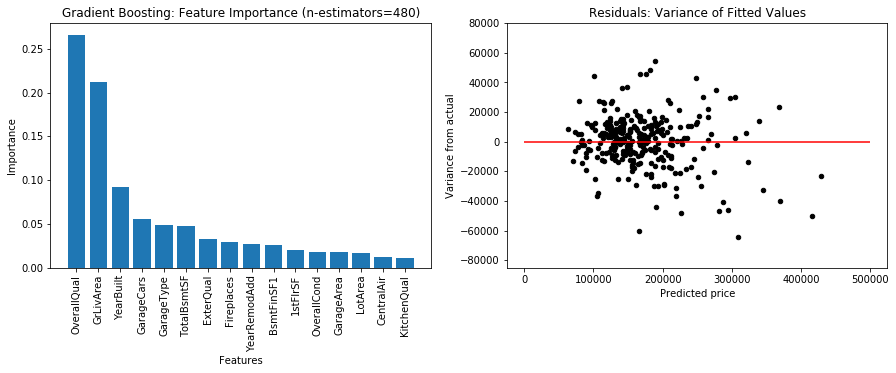

In [64]:
def gradient_boost(n_estimators=100, learning_rate=0.1, encoder='none', plots=False, train=train, test=test):
    
    full_data = transform_categorical(encoder=encoder)
    
    # Encode and split dataset 
    train_data, train_labels, dev_data, dev_labels, test_data = split_full_dataset(full_data, train=train)
    train_labels_log, dev_labels_log = np.log(train_labels), np.log(dev_labels)
    
    # Gradient Boosting - fit the model
    gbm = GradientBoostingRegressor(n_estimators=n_estimators, learning_rate=learning_rate, random_state=0)
    gbm.fit(train_data, train_labels_log)

    # Predictions
    predict_dev_log = gbm.predict(dev_data)
    predict_dev_value = np.exp(predict_dev_log)

    # Parameters and results
    print('Gradient Boosting Regression with',encoder)
    print('N-estimators: {}'.format(n_estimators))
    print('R^2: {:.4f}'.format(gbm.score(dev_data, dev_labels_log)))
    print('RMSE: {:.4}'.format(root_mean_squared_error(dev_labels_log, predict_dev_log)))
    
    if plots == True:
        
        # Feature importance
        train_trim = train.loc[:, train.columns != 'SalePrice']
        importance = pd.DataFrame({'feature': train_trim.columns, 'importance': gbm.feature_importances_})
        importance.sort_values(by='importance', ascending=False, inplace=True)
        trimmed_features = importance.loc[importance['importance'] > 0.01]

        # Plot feature importance
        fig, (ax1, ax2) = plt.subplots(1,2,figsize = (15,4.5))
        ax1.bar(trimmed_features['feature'], trimmed_features['importance'])

        ax1.set_title('Gradient Boosting: Feature Importance (n-estimators={})'.format(n_estimators))
        ax1.set_ylabel('Importance')
        ax1.set_xlabel('Features')

        # Rotate x labels
        for tick in ax1.get_xticklabels():
            tick.set_rotation(90)

        # Plot residuals
        ax2.scatter(predict_dev_value, predict_dev_value - dev_labels, color='black', s=20)
        ax2.hlines(y=0, xmin= 0, xmax=500000, colors='red')

        ax2.set_title('Residuals: Variance of Fitted Values')
        ax2.set_xlabel('Predicted price')
        ax2.set_ylabel('Variance from actual')
        ax2.set_ylim(-85000,80000)
    
gradient_boost(n_estimators=480, learning_rate=0.03, encoder='label_encoder', plots=True)

Gradient Boosting Regression, using the optimized parameters of 480 estimators and a learning rate of 0.03, resulted in an R^2 of 0.9104.  Gradient Boosting is a highly effective method that captures a substantial amount of variance in sthe dependent variable, second only to Lasso Regression with one hot encoding (R^2 of 0.9223).  It however has the added benefit of homoskedasticity, exhibiting constant variance as sales price increases. 

In gradient boosting each feature is assigned a measure of importance and the total importance for all fitted features sums to 1.  Overall Quality and Ground Living Area combined have an importance of almost 0.5, meaning that these two features carry roughly the same importance (in terms of ability to estimate sale price) as the remaining 77 features combined.  Similar to the regularized Lasso Regression model, Overall Quality is found to be the most important feature when predicting sales price.  

An additional observation is that neighborhood does not appear to be important feature in determining sales price.  This is contrary to common knowledge given that neighborhoods which are safe, have good schools and therefore more affluent typically have more expensive homes, compared to lower socio-economic communities.  A potential explanation for the lack of neighborhood effect is that the dataset is based solely on homes in Ames, Iowa.  With a population of just 65,000, it's quite possible this city isn't economically diverse enough for neighborhood to have much bearing on house sales price. Alternatively, the variances between neighborhoods could be captured by other features in the dataset such as Overall Quality and Overall Condition.

### Voting Regression

Ensemble models are effective in regression (or classification) tasks because they leverage multiple learners to create a stronger one. Similarly, it is possible to construct a regression model that is greater than the sum of its parts by combining multiple different models together and taking the average of the predictions - this is called Voting Regression.

Voting Regression using gradient boosting and lasso
Encoding: onehot_encoder
Accuracy: 0.9232
RMSE: 0.1037


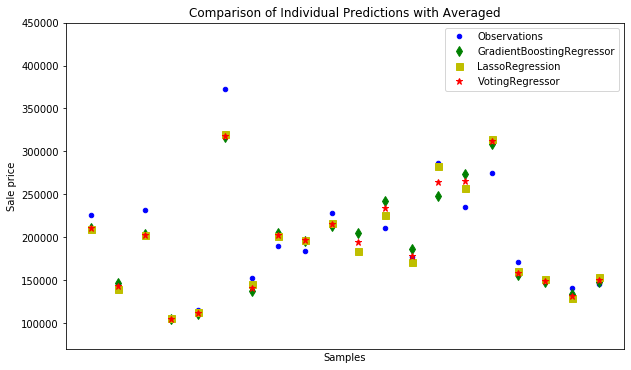

In [65]:
def voting_regression(encoder='none', train=train, test=test):
    
    full_data = transform_categorical(encoder=encoder)
    
    # Encode and split dataset 
    train_data, train_labels, dev_data, dev_labels, test_data = split_full_dataset(full_data, train=train)
    train_labels_log, dev_labels_log = np.log(train_labels), np.log(dev_labels)

    # Multiple regression models for voting
    gbm = GradientBoostingRegressor(n_estimators=380, learning_rate=0.03, random_state=0)
    lasso = Lasso(alpha=0.0001, normalize=True)
    vreg = VotingRegressor([('gbm', gbm), ('lasso', lasso)])

    # Fit models
    gbm.fit(train_data, train_labels_log)
    lasso.fit(train_data, train_labels_log)
    vreg.fit(train_data, train_labels_log)

    # Obtain sample of observations
    dev_trimmed = dev_data[30:50]
    
    # Predict sales price for sample
    gbm_predict_dev = np.exp(gbm.predict(dev_trimmed))
    lasso_predict_dev = np.exp(lasso.predict(dev_trimmed))
    vreg_predict_dev = np.exp(vreg.predict(dev_trimmed))

    fig, ax = plt.subplots(figsize = (10,6))
    
    plt.plot(np.array(dev_labels[30:50]), 'b.', ms=9, label='Observations')
    plt.plot(gbm_predict_dev, 'gd', ms=7, label='GradientBoostingRegressor')
    plt.plot(lasso_predict_dev, 'ys', ms=7, label='LassoRegression')
    plt.plot(vreg_predict_dev, 'r*', ms=7, label='VotingRegressor')
    plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
    
    plt.title('Comparison of Individual Predictions with Averaged')
    plt.ylabel('Sale price')
    plt.xlabel('Samples')
    plt.ylim(70000,450000)
    plt.legend(loc='best')
    
    print('Voting Regression using gradient boosting and lasso')
    print('Encoding:', encoder)
    print('Accuracy: {:.4f}'.format(vreg.score(dev_data, dev_labels_log)))
    print('RMSE: {:.4}'.format(root_mean_squared_error(dev_labels_log, vreg.predict(dev_data))))
    
voting_regression(encoder='onehot_encoder')

The Voting Regressor made predictions using the optimized models of gradient boosting and lasso regression, yielding an R^2 of 0.9232.  By averaging the predictions of these two models, the voting regressor was able to predict sales price with greater accuracy than either of the individual models - the R^2 of gradient boosting and lasso were 0.9223 and 0.9098, respectively.  

Combing multiple models together to create a stonger learner is a highly effective approach which can take many forms in machine learning, whether boosting, bagging or stacking.  The Voting Regressor is particularly effective as it leverages the individual characteristics of each input model to arrive at a prediction that is consensus-driven. The Voting Regressor is therefore somewhat analogous to decision-making in government where the individual perspectives and motivations of each governement representative helps to shape a final decision that is more robust through consensus.

In [66]:
lasso_regression(alphas=np.arange(0,0.001,0.0001), encoder='onehot_encoder', transform=True)

Lasso Regression with onehot_encoder
Best alpha: 0.0001
Features: 137
R^2: 0.9223
RMSE: 0.1043


In [67]:
gradient_boost(n_estimators=480, learning_rate=0.03, encoder='onehot_encoder')

Gradient Boosting Regression with onehot_encoder
N-estimators: 480
R^2: 0.9098
RMSE: 0.1123


### Model Optimization with Grid Search

In [90]:
def lasso_grid_search(train=train, test=test):
    '''Fit GridSearchCV using lasso regression for various
    alpha. Accepts input of full_data and returns (prints)
    the best model score and corresponding alpha.
    '''
    full_data = encode_data(encoder='label_encoder')
    
    # Encode and split dataset 
    train_data, train_labels, dev_data, dev_labels, test_data = split_full_dataset(full_data, train=train)
    train_labels_log, dev_labels_log = np.log(train_labels), np.log(dev_labels)

    # Parameters
    model = Lasso(normalize=True)
    param_grid = {'alpha': np.arange(0,0.01,0.0001)}
    
    # Fit grid search
    grid_search = GridSearchCV(estimator=model, param_grid=param_grid)
    grid_search.fit(train_data, train_labels_log)

    # Make predictions
    predict_dev_log = grid_search.predict(dev_data)
    predict_dev_value = np.exp(predict_dev_log)

    # summarize the results of the grid search
    print('Lasso Regression')
    print('Best score: {:.3f}'.format(grid_search.best_score_))
    print('Best estimator: {}'.format(grid_search.best_estimator_.alpha))

lasso_grid_search()

Lasso Regression
Best score: 0.841
Best estimator: 0.0004


In [87]:
def gboost_grid_search(train=train, test=test):
    '''Fit GridSearchCV using lasso regression for various
    alpha. Accepts input of full_data and returns (prints)
    the best model score and corresponding alpha.
    '''
    full_data = transform_categorical(encoder='label_encoder')
    
    # Encode and split dataset 
    train_data, train_labels, dev_data, dev_labels, test_data = split_full_dataset(full_data, train=train)
    train_labels_log, dev_labels_log = np.log(train_labels), np.log(dev_labels)

    # Parameters
    model = GradientBoostingRegressor(random_state=0)
    param_grid = {'n_estimators': np.arange(479,481,1),
                  'learning_rate': np.arange(0.01,0.04,0.02)}
    
    # Fit grid search
    grid_search = GridSearchCV(estimator=model, param_grid=param_grid)
    grid_search.fit(train_data, train_labels_log)

    # Make predictions
    predict_dev_log = grid_search.predict(dev_data)
    predict_dev_value = np.exp(predict_dev_log)

    # summarize the results of the grid search
    print('Gradient Boosting Regression')
    print('Best score: {:.3f}'.format(grid_search.best_score_))
    print('Best estimator: {}'.format(grid_search.best_estimator_.n_estimators))
    print('Best learning rate: {:.2f}'.format(grid_search.best_estimator_.learning_rate))

gboost_grid_search()

Gradient Boosting Regression
Best score: 0.887
Best estimator: 480
Best learning rate: 0.03


### Principal Component Analysis

In [92]:
def pca_components(n=10, encoder='none', train=train, test=test):
    '''Print the explained variance by the top n principal components.
    '''
    full_data = transform_categorical(encoder=encoder)
    
    # Encode and split dataset 
    train_data, train_labels, dev_data, dev_labels, test_data = split_full_dataset(full_data, train=train)
    train_labels_log, dev_labels_log = np.log(train_labels), np.log(dev_labels)
    
    n_components = np.arange(1,n+1)
    individuals = []

    # Fit Principal Component Analysis (PCA) 
    pca = PCA(n_components=n)
    pca.fit(train_data)
    
    print('Fraction of variance explained by first {} principal components:'.format(n))

    # Cumulative sum of variance explained for each n_compoents
    for i, n in enumerate(n_components):
        individuals.append(pca.explained_variance_ratio_[i])
        print('#{}: {:.5f}'.format(n, pca.explained_variance_ratio_[i]))

pca_components(encoder='label_encoder')

Fraction of variance explained by first 10 principal components:
#1: 0.98177
#2: 0.00530
#3: 0.00354
#4: 0.00293
#5: 0.00282
#6: 0.00206
#7: 0.00049
#8: 0.00032
#9: 0.00025
#10: 0.00019


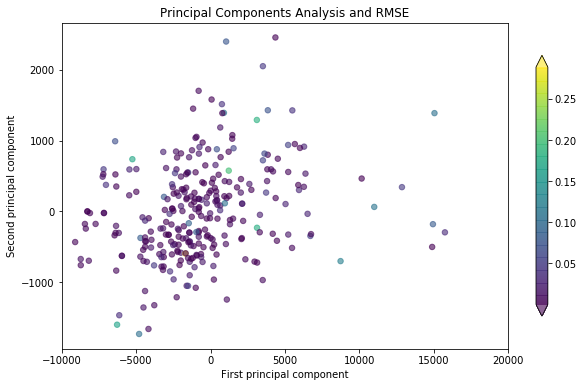

In [95]:
def pca_plot(encoder='none', train=train, test=test):
    '''Reduce observations to two principal components
    and plot the root mean squared error between
    predicted and true sale price.
    '''
    full_data = transform_categorical(encoder=encoder)
    
    # Encode and split dataset 
    train_data, train_labels, dev_data, dev_labels, test_data = split_full_dataset(full_data, train=train)
    train_labels_log, dev_labels_log = np.log(train_labels), np.log(dev_labels)

    # Fit the linear regression model
    lr = LinearRegression()
    lr.fit(train_data, train_labels_log)
    predict_dev_log = lr.predict(dev_data)
    predict_dev_value = np.exp(predict_dev_log)

    # PCA - fit and transform to 2-dimensions
    pca = PCA(n_components=2)
    dev_data_pca = pca.fit_transform(dev_data)

    squared_error = np.square(dev_labels_log - predict_dev_log)

    fig, ax = plt.subplots(figsize = (10,6))
    SC = ax.scatter(dev_data_pca[:,0], dev_data_pca[:,1], c=squared_error, s=30, alpha=0.6)
    CB = plt.colorbar(SC, shrink=0.8, extend='both')
    plt.title('Principal Components Analysis and RMSE')
    plt.xlabel('First principal component')
    plt.ylabel('Second principal component')

    ax.set_xlim(-10000,20000)
    
pca_plot(encoder='label_encoder')